In [ ]:
import os 
import pandas as pd
import numpy as np 
import geopandas as gpd
import json
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
import re 
import matplotlib.pyplot as plt
import seaborn as sns 
import imageio

In [2]:
populationProjectionsData  = pd.read_excel('../Data/UN_PPP2024_Output_PopTot.xlsx',  skiprows=16, sheet_name='Median')
mapCountries = gpd.read_file('../Data/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp')


In [3]:
mapCountries.columns

Index(['featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3',
       'ADM0_DIF', 'LEVEL', 'TYPE', 'TLC', 'ADMIN',
       ...
       'FCLASS_TR', 'FCLASS_ID', 'FCLASS_PL', 'FCLASS_GR', 'FCLASS_IT',
       'FCLASS_NL', 'FCLASS_SE', 'FCLASS_BD', 'FCLASS_UA', 'geometry'],
      dtype='object', length=169)

In [4]:

populationProjectionsData.columns = [str(x).lower().replace(',', '') for x in  populationProjectionsData.columns]

populationProjectionsData.columns= [re.sub(r'[^\w\s]', '', x) for x in populationProjectionsData.columns]

populationProjectionsData.columns = [re.sub(r'\s+$', '', x) for x in  populationProjectionsData.columns]
populationProjectionsData.columns = populationProjectionsData.columns.str.replace(' ', '_')


populationProjectionsData.rename(columns={'region_subregion_country_or_area': 'filter_area_type'}, inplace=True)

mapCountries.columns =  [x.lower() for x in  mapCountries.columns]


In [5]:
mapCountries= mapCountries[['featurecla', 'scalerank', 'labelrank', 'sovereignt', 'sov_a3','adm0_diff', 'level', 'type', 'tlc', 'admin', 'adm0_a3', 'geounit',
              'name', 'name_long', 'postal', 'economy', 'iso_a3', 'adm0_iso', 'wikidataid', 'name_en', 'name_es', 'continent','region_un',  'geometry']]

In [6]:
populationProjectionsData = populationProjectionsData[['index', 'variant', 'filter_area_type', 'location_code', 'iso3_alphacode', 'iso2_alphacode', 'type', '2024', '2030', '2050', '2075', '2100']]

populationProjectionsData= populationProjectionsData[(populationProjectionsData['iso3_alphacode'].notnull()) & (populationProjectionsData['type']=='Country/Area')]


In [7]:
populationProjectionsData = populationProjectionsData.astype({'2024': 'float', '2030': 'float', '2050': 'float', '2075': 'float', '2100': 'float'})
# populationProjectionsData['2024'] = populationProjectionsData['2024'].astype(float)

In [8]:
populationProjectionsDataLong = pd.melt(populationProjectionsData, value_vars = ['2024', '2030', '2050', '2075', '2100'], 
        id_vars= ['index', 'variant', 'filter_area_type', 'location_code', 'iso3_alphacode', 'iso2_alphacode', 'type'])


populationProjectionsDataLong.rename(columns={'variable': 'year', 'value': 'population'}, inplace=True)



In [9]:
populationProjectionsDataLong[populationProjectionsDataLong['iso3_alphacode']=='PRT']

,index,variant,filter_area_type,location_code,iso3_alphacode,iso2_alphacode,type,year,population
145,199,Median PI,Portugal,620,PRT,PT,Country/Area,2024,10425.292
382,199,Median PI,Portugal,620,PRT,PT,Country/Area,2030,10317.927
619,199,Median PI,Portugal,620,PRT,PT,Country/Area,2050,9770.270
856,199,Median PI,Portugal,620,PRT,PT,Country/Area,2075,8942.124
1093,199,Median PI,Portugal,620,PRT,PT,Country/Area,2100,8753.987


In [10]:
mapCountries[mapCountries['name_en']=='France']
mapCountries['iso_a3'] = np.where(mapCountries['adm0_iso']=='FRA', 'FRA', mapCountries['iso_a3'])

In [11]:
populationProjectionsDataNew = pd.merge(populationProjectionsDataLong, mapCountries, left_on='iso3_alphacode', right_on='iso_a3')
#populationProjectionsDataNew = pd.merge(populationProjectionsDataLong, mapCountries, left_on='iso3_alphacode', right_on='adm0_iso')

In [12]:
populationProjectionsDataNew['year'] = populationProjectionsDataNew['year'].astype(int)

populationProjectionsDataNew['population'] = populationProjectionsDataNew['population'].astype(float)

populationProjectionsDataNew['population'] = populationProjectionsDataNew['population']*1000.0

years = sorted(populationProjectionsDataNew['year'].unique())

In [13]:
#population_bins =  [float(x) for x in [0, 1e5, 1e6, 1e7, 1e8, 1e9, 5e9, 1e10]]
#population_labels = ['<100K', '100K-1M', '1M-10M', '10M-100M', '>100M', '>500M', '>1000M']

population_bins =  [float(x) for x in [0, 1e7, 1e8, 5e8, 1e9, float('inf')]]
population_labels = ['<10M', '10M-100M', '>100M', '>500M', '>1000M']


populationProjectionsDataNew['population_category'] = pd.cut(populationProjectionsDataNew['population'], bins=population_bins, labels=population_labels, include_lowest=True)

In [14]:
populationProjectionsDataNew = gpd.GeoDataFrame(populationProjectionsDataNew, crs="EPSG:4326")

In [15]:
test = populationProjectionsDataNew[populationProjectionsDataNew['year']==2024]


C:\Users\fernando.dorantes\AppData\Local\Temp\ipykernel_26568\3275856467.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis_original=plt.cm.get_cmap('viridis')


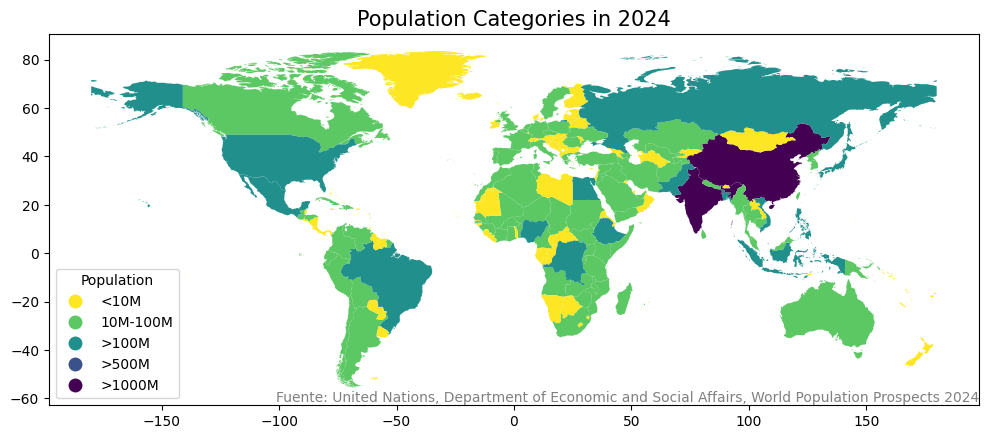

In [16]:

viridis_original=plt.cm.get_cmap('viridis')
viridis_reverse = viridis_original.reversed() 
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.set_title(f"Population Categories in 2024", fontsize=15)
test.plot(column='population_category', cmap=viridis_reverse, legend=True, ax=ax,  legend_kwds={'title': "Population", 'loc': 'lower left'})
plt.text(1, 0, 'Fuente: United Nations, Department of Economic and Social Affairs, World Population Prospects 2024', 
             fontsize=10, color='gray', ha='right', va='bottom', transform=ax.transAxes)
plt.show()




In [ ]:
images= []
for year in years:
    yearly_data = populationProjectionsDataNew[populationProjectionsDataNew['year'] == year]

    # Crear la figura y el mapa
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    ax.set_title(f"Population Categories in {year}", fontsize=15)
    
    viridis_original=plt.cm.get_cmap('viridis')
    viridis_reverse = viridis_original.reversed()

    yearly_data.plot(column='population_category', cmap=viridis_reverse, legend=True, ax=ax,
                     legend_kwds={'title': "Population", 'loc': 'lower left'})

    plt.text(1, 0, 'Fuente: United Nations, Department of Economic and Social Affairs, World Population Prospects 2024', 
             fontsize=10, color='#7393B3', ha='right', va='bottom', transform=ax.transAxes,  weight='bold')
    ax.set_axis_off()
    
    # Guardar la imagen temporalmente
    filename = f"map_{year}.png"
    plt.savefig(filename, format="png", dpi=100)
    images.append(imageio.imread(filename))
    plt.close()


imageio.mimsave("../images/population_map_animation.gif", images, duration=2000)

for filename in [f"map_{year}.png" for year in years]:
    os.remove(filename)

print("Animación guardada como 'population_map_animation.gif'")

C:\Users\fernando.dorantes\AppData\Local\Temp\ipykernel_36452\2087264890.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis_original=plt.cm.get_cmap('viridis')
C:\Users\fernando.dorantes\AppData\Local\Temp\ipykernel_36452\2087264890.py:22: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))
C:\Users\fernando.dorantes\AppData\Local\Temp\ipykernel_36452\2087264890.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get

Animación guardada como 'population_map_animation.gif'
